In [ ]:
#import numpy as np
%matplotlib inline
from numpy import *
from time import sleep
import matplotlib.pyplot as plt

In [ ]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn);
    labelMat = mat(classLabels).transpose() # 原本的classLabels是行向量
    b = 0
    m,n = shape(dataMatrix)
    alphas = mat(zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            fXi = float( multiply(alphas,labelMat).T * (dataMatrix*dataMatrix[i,:].T) ) + b
            Ei = fXi - float(labelMat[i]) 
            #if checks if an example violates KKT conditions
            # 不在间隔边界上的点，必有alpha = C 或者 alpha = 0
            # 这里只针对第一个变量，选择违反了KKT条件的点，且是选择第一个违反KKT条件的点，而不是选择违反最厉害的点
            # 而且第二个点也是随机选的。
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)
                fXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy()  #需要使用copy，保存旧值
                alphaJold = alphas[j].copy()
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: 
                    print "L==H"
                    continue
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                #eta 应该小于 0
                if eta >= 0: 
                    print "eta>=0"
                    continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): 
                    print "j not moving enough"   # 如果 alphaJ 变化不大，还不如不变，理论与实际的差异
                    continue
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - \
                             labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - \
                             labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                # 这里的 b 值的更新，应该不符合统计学习方法中说的
                # 统计学习方法中说的是，如果 alphaI 和 alphaJ 同时满足0 ~ C，则 b1 = b2，
                # 如果有一个为 0 或者 C，则取中点
                if (0 < alphas[i]) and (C > alphas[i]): 
                    b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): 
                    b = b2
                else: 
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                # 这里 iter 为 外层循环，即while循环，
                # 第 i 次迭代，每次迭代，多少对 alpha 被改变了
                print "iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
        # 下面的条件判断使得，只有当每个 alpha 都满足条件时，会将iter
        #  由于 第二个变量是随机的，所以只有在多次确定没有变化后，才能退出程序
        if (alphaPairsChanged == 0): 
            iter += 1
        else: 
            iter = 0
        print "iteration number: %d" % iter
    return b,alphas

In [ ]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj


In [153]:
## 有核 SVM
class optStructK:
    def __init__(self, dataMatIn, classLabels, C = 0.06, toler = 0.001, kTup=('lin', 0)):
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m, 1)))
        self.b = 0
        self.eCahce = mat(zeros((self.m, 2)))
        self.K = mat(zeros((self.m, self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTransK(self.X, self.X[i, :], kTup)
        
def kernelTransK(X, A, kTup):
    m,n = shape(X)
    K = mat(zeros((m, 1)))
    if kTup[0] == 'lin':
        K = X * A.T  # 没有核函数的情况
    elif kTup[0] == 'rbf':
        # 高斯核函数的情况
        # 下面的kTup[1]是 \sigma^2
        for j in range(m):
            deltaRow = X[j, :] - A
            K[j] = deltaRow * deltaRow.T
        K = exp( K / (-1*kTup[1]*2) )
    else:
        raise NameError('Houston We Have a Problem -- That Kernel is not recognized')
    return K

def calcEkK(oS, k):
    fXk = float(multiply(oS.alphas, oS.labelMat).T * oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
    
def selectJK(i, oS, Ei):
    maxk = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCahce[i] = [1,Ei]
    validEcacheList = nonzero(oS.eCahce[:,0].A)[0]
    if len(validEcacheList) > 1:
        for  k in validEcacheList:
            if k == i:
                continue
            Ek = calcEkK(oS, k)
            deltaE = abs(Ei - Ek)
            if deltaE > maxDeltaE:
                maxDeltaE = deltaE
                Ej = Ek
                maxk = k
        return maxk, Ej
    else:
        j = selectJrand(i, oS.m)
        Ej = calcEkK(oS, j)
    return j, Ej

def updateEkK(oS, k):
    Ek = calcEkK(oS, k)
    oS.eCahce[k] = [1, Ek]

def innerLK(i, oS):
    Ei = calcEkK(oS, i)
    if  (oS.labelMat[i]*Ei < -oS.tol and oS.alphas[i] < oS.C) or \
        (oS.labelMat[i]*Ei > oS.tol and oS.alphas[i] > 0):
        j, Ej = selectJK(i, oS, Ei)
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if oS.labelMat[i] != oS.labelMat[j]:
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L == H:
            #print 'L==H'
            return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >= 0:
            #print 'eta >= 0'
            return 0
        oS.alphas[j] = oS.alphas[j] - oS.labelMat[j] * (Ei - Ej) / eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], H, L)
        updateEkK(oS, j)
        if abs(oS.alphas[j] - alphaJold) < 0.00001:
            #print 'j not moving enough'
            return 0
        oS.alphas[i] = oS.alphas[i] + (oS.labelMat[i]*oS.labelMat[j]) * (alphaJold - oS.alphas[j])
        updateEkK(oS, i)
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - \
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- \
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if 0 < oS.alphas[i] and oS.alphas[i] < oS.C:
            oS.b = b1
        elif 0 < oS.alphas[j] and oS.alphas[j] < oS.C:
            oS.b = b2
        else :
            oS.b = (b1 + b2) / 2
        return 1
    else:
        return 0
    
def smoPK(dataMatIn, classLabels, C = 0.6, toler = 0.001, maxIter = 40, kTup=('lin', 0)):
    oS = optStructK(mat(dataMatIn), mat(classLabels).transpose(), C, toler, kTup)
    iterr = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iterr < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                #print "fullSet, iterr: %d i:%d, pairs changed %d" % (iterr,i,alphaPairsChanged)
            iterr += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                #print type(i)
                alphaPairsChanged += innerLK(i,oS)
                #print "non-bound, iterr: %d i:%d, pairs changed %d" % (iterr,i,alphaPairsChanged)
            iterr += 1
        if entireSet: 
            entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): 
            entireSet = True  
        print "iteration number: %d" % iterr
    return oS.b, oS.alphas

In [ ]:
## 有核 svm 测试
dataArr, labelArr = loadDataSet('testSet.txt')
b, alphas = smoPK(dataArr, labelArr, 0.6, 0.001, 40, ('lin',0))
#print type(b)
w = calcWs(alphas, dataArr, labelArr)
b0 = b.A[0,0]
w1 = w[0,0]
w2 = w[1,0]
print w1, w2, b0

x1 = np.linspace(-2, 10, 13, endpoint=True)
x2 = []
for xx1 in x1:
    x2.append(-1*(b0 + w1*xx1) / w2)

dataMat = mat(dataArr)
X = dataMat[:,0]
Y = dataMat[:,1]
plt.figure()
plt.plot(x1, x2)
plt.plot(X,Y,'o')
plt.show()


iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
there are 47 support vectors
the training error rate is 0.060000 
the testing error rate is 0.130000
(44,) (56,)


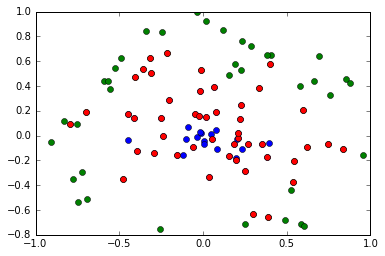

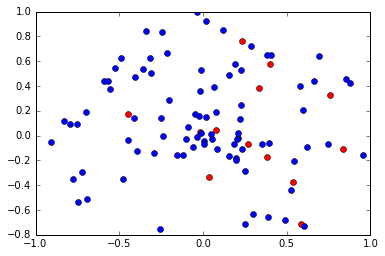

In [194]:
def testRBF(k1 = 1.3):
    dataArr, labelArr = loadDataSet('testSetRBF.txt')
    b, alphas = smoPK(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1))
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    svInd = nonzero(alphas.A > 0)[0]  #支持向量 
    sVs = dataMat[svInd]
    labelSV = labelMat[svInd]
    print 'there are %i support vectors' % shape(sVs)[0]
    m,n = shape(dataMat)
    errorCount = 0
    errorInd_train = []
    corrInd_train = []
    for i in range(m):
        kernelEval = kernelTransK(sVs, dataMat[i,:],('rbf', k1)) # 因为非支持向量的alphas为0
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]):
            errorCount += 1
            errorInd_train.append(i)
        else:
            corrInd_train.append(i)
    print "the training error rate is %f " % (float(errorCount) / m)
    
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    errorInd_test = []
    corrInd_test = []
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    m,n = shape(dataMat)
    for i in range(m):
        kernelEval = kernelTransK(sVs, dataMat[i,:], ('rbf', k1))
        predict = kernelEval.T * multiply(labelSV, alphas[svInd]) + b
        if sign(predict) != sign(labelArr[i]):
            errorCount += 1
            errorInd_test.append(i)
        else:
            corrInd_test.append(i)
    print "the testing error rate is %f" % (float(errorCount) / m)
    
    # 画出训练集中的正例和负例
    dataArr, labelArr = loadDataSet('testSetRBF.txt')
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    posInd = nonzero(labelMat[:,0] == 1)[0]
    negInd = nonzero(labelMat[:,0] == -1)[0]
    print posInd.shape, negInd.shape
    pos_data = dataMat[posInd]
    neg_data = dataMat[negInd]
    sv_data = dataMat[svInd]
    plt.figure()
    plt.plot(pos_data[:,0], pos_data[:,1], 'bo')
    plt.plot(neg_data[:,0], neg_data[:,1], 'go')
    plt.plot(sv_data[:,0], sv_data[:,1], 'ro')
    
    # 画出训练集中误分类的点
    error_data = dataMat[errorInd_test]
    corr_data = dataMat[corrInd_test]
    plt.figure()
    plt.plot(error_data[:,0], error_data[:,1], 'ro')
    plt.plot(corr_data[:,0], corr_data[:,1], 'bo')
   
    
    
    # 画出测试集中误分类的点
    dataArr, labelArr = loadDataSet('testSetRBF2.txt')
    dataMat = mat(dataArr)
    labelMat = mat(labelArr).transpose()
    

testRBF(4)
# k1为0.001时有98个sv，训练错误率为0，测试错误率为0.23
# k1为0.005时有89个sv，训练错误率为0，测试错误率为0.07
# k1为0.01时有78个sv，训练错误率为0，测试错误率为0.06
# k1为0.02时有43个sv，训练错误率为0，测试错误率为0.05
# k1为0.05时有25个sv，训练错误率为0.，测试错误率为0.07
# k1为0.08时有23个sv，训练错误率为0.01，测试错误率为0.04
# k1为0.1时有20个sv，训练错误率为0.01，测试错误率为0.08
# k1为0.2时有17个sv，训练错误率为0.03，测试错误率为0.08
# 大致趋势是，k1增加，支持向量减少，训练错误率上升，测试错误减小，支持向量的数目存在一个最优值，
# k1为1时有27个sv，训练错误率为0.05，测试错误率为0.07
# k1为1.5时有30个sv，训练错误率为0.04，测试错误率为0.05
# k1为1.8时有30个sv，训练错误率为0.05，测试错误率为0.12
# k1为2时有36个sv，训练错误率为0.23，测试错误率为0.32

In [174]:
labelMat.shape

(100, 1)

(44,) (56,)


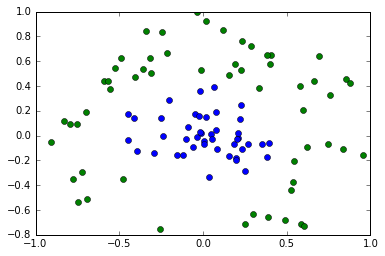

In [140]:
dataArr, labelArr = loadDataSet('testSetRBF.txt')
dataMat = mat(dataArr)
labelMat = mat(labelArr).transpose()
posInd = nonzero(labelMat[:,0] == 1)[0]
negInd = nonzero(labelMat[:,0] == -1)[0]
print posInd.shape, negInd.shape
pos_data = dataMat[posInd]
neg_data = dataMat[negInd]
plt.figure()
plt.plot(pos_data[:,0], pos_data[:,1], 'bo')
plt.plot(neg_data[:,0], neg_data[:,1], 'go')

In [ ]:
##　无核SVM
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        
def calcEk(oS, k):
    #print 'calc1'
    fXk = float(multiply(oS.alphas, oS.labelMat).T * (oS.X * oS.X[k,:].T) ) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    # 找到 eCache 的第一列中不为0的行的索引
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: 
                continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]  #置 1 个毛线，有屁用，又没用重置为 0 
        
def innerL(i, oS):
    #print 'inner1'
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        #print 'inner2'
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: 
            print "L==H"
            return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: 
            print "eta>=0"
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        # TMD，你都已经更新，尼玛又不接着更新其他值，
        # CNM，书上说每次更新完 两个alpha后，就要重新计算 b 值，计算 b 值之后，相应的 E 也要更新。
        # 也就说 E 应该是在 b 之后更新。
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            print "j not moving enough"
            return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - \
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - \
                        oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): 
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): 
            oS.b = b2
        else: 
            oS.b = (b1 + b2)/2.0
        return 1
    else: 
        return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter):    #full Platt SMO
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler)
    iterr = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iterr < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        print "iteration number: %d" % iterr
        alphaPairsChanged = 0
        if entireSet:   #go over all
            # 第一遍会遍历整个训练集
            # 
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print "fullSet, iterr: %d i:%d, pairs changed %d" % (iterr,i,alphaPairsChanged)
            iterr = iterr + 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0] # 浪费，innerL里面是已经对非边界alpha比较了吗，艹
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print "non-bound, iterr: %d i:%d, pairs changed %d" % (iterr,i,alphaPairsChanged)
            iterr += 1
        # 第一次运行，运行第一个for循环，
        # 若有更改，alphaParisChanged > 0，entire被设置为False
        # 若没有更改，entire始终为True，始终运行第一个for循环，
        # 第二次运行，运行第二个for循环
        # 若有更改，则此时entire不变，仍然为False，那么以后一直都运行第二个for循环
        # 若没有更改，则entire设置为True，然后运行第一个for循环
        # 最有可能的运行情况是，第一次运行第一个for循环，中间的次数都运行第二个for循环，直到找到最优解，
        # 找到最优解后，entire为False，alphaParisChanged为0，此时退出循环
        if entireSet: 
            entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): 
            entireSet = True  
        
    print 'train over'
    return oS.b,oS.alphas

def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [ ]:
## 无核 svm 测试
dataArr, labelArr = loadDataSet('testSet.txt')
b, alphas = smoP(dataArr, labelArr, 0.6, 0.001, 60)
w = calcWs(alphas, dataArr, labelArr)
b0 = b.A[0][0]
w1 = w[0,0]
w2 = w[1,0]
w1, w2, b0

x1 = np.linspace(-2, 10, 13, endpoint=True)
x2 = []
for xx1 in x1:
    x2.append(-1*(b0 + w1*xx1) / w2)

dataMat = mat(dataArr)
X = dataMat[:,0]
Y = dataMat[:,1]
plt.figure()
plt.plot(x1, x2)
plt.plot(X,Y,'o')
plt.show()
